In [1]:
import os
from pcxarray import pc_query, prepare_timeseries
from pcxarray.utils import load_census_shapefile
from distributed import Client # dask distributed client
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

In [2]:
client = Client(n_workers=os.cpu_count(), memory_limit="2GB")
display(client)

/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45891 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:40327' processes=24 threads=24, memory=44.70 GiB>

In [3]:
okt_gdf = load_census_shapefile(level="county", verify=False)
okt_gdf = okt_gdf[okt_gdf['NAME'] == "Oktibbeha"]
okt_gdf = okt_gdf.to_crs("EPSG:32616") # UTM zone 16N

selected_geom = okt_gdf.geometry.union_all()

In [4]:
items_gdf = pc_query(
    collections=["sentinel-2-l2a"],
    geometry=selected_geom,
    datetime='2024', # grab all of 2024
    crs=okt_gdf.crs,
    query={"eo:cloud_cover": {"lt": 50}} # return scenes with less than 50% cloud cover
)
print(f"Found {len(items_gdf)} items in the query.")

Found 292 items in the query.


In [5]:
da = prepare_timeseries(
    items_gdf=items_gdf,
    geometry=selected_geom,
    crs=okt_gdf.crs,
    bands=["B02", "B04", "B08", "SCL"], # Blue, Red, NIR, Scene Classification Layer
    chunks={"time": 1, "x": 2048 , "y": 2048 }, 
    masked=True,
    max_workers=4,
)


Processing items: 100%|██████████| 81/81 [20:18<00:00, 15.04s/timestep]


In [6]:
def calculate_evi(da):
    nir = da.sel(band="B08") / 10000
    red = da.sel(band="B04") / 10000
    blue = da.sel(band="B02") / 10000
    
    evi = 2.5 * (nir - red) / (nir + (6 * red) - (7.5 * blue) + 1)
    evi = evi.clip(-1, 1)  # Clip values to [-1, 1]
    return evi

da = da.where(~da.sel(band="SCL").isin([0, 3, 8, 9, 10, 11])) # mask out clouds, shadows, and snow
evi = calculate_evi(da)
monthly_evi = evi.resample(time="1M").mean().compute()

/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


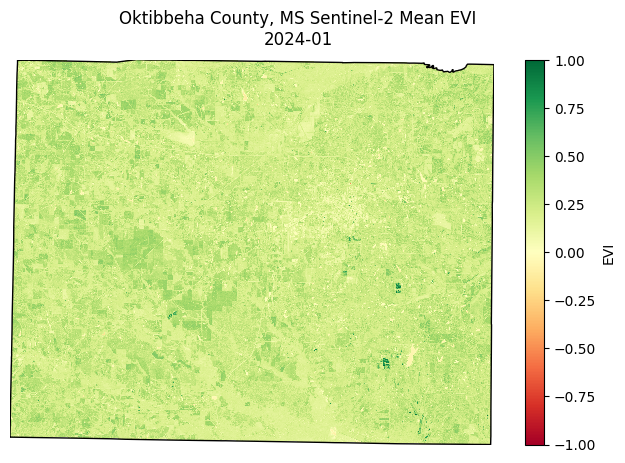

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

def update(frame):
    ax.clear()
    # ax.imshow(monthly_evi.isel(time=frame), add_colorbar=False, cmap='RdYlGn', vmin=-1, vmax=1)
    monthly_evi.isel(time=frame).plot.imshow(
        ax=ax, add_colorbar=False, cmap='RdYlGn', vmin=-1, vmax=1
    )

    ax.set_title(None)
    ax.set_aspect('equal')
    ax.axis('off')
    x_lim, ylim = ax.get_xlim(), ax.get_ylim()
    okt_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
    
    ax.set_xlim(x_lim)
    ax.set_ylim(ylim)
    
    fig.suptitle(f"Oktibbeha County, MS Sentinel-2 Mean EVI\n" + \
        f"{monthly_evi['time'][frame].dt.strftime('%Y-%m').values}")
    
init_plot = monthly_evi.isel(time=0).plot.imshow(
    ax=ax, add_colorbar=True, cbar_kwargs={'label': 'EVI'},cmap='RdYlGn', vmin=-1, vmax=1
)

ani = FuncAnimation(fig, update, frames=len(monthly_evi['time']), repeat=False)

# show in notebook
HTML(ani.to_jshtml(fps=1, default_mode='once')) 

# plt.close()